# Branch Classifier

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [13]:
from datetime import datetime
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import torch

sys.path.append("../")
from data_prep import collect, load
from solvers import branch_classifier
import models
DATE = datetime.now().strftime("%m-%d-%y")
DTYPE = torch.float32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## Collect branch classifier training data
Training data consists of volumetric image patches chosen randomly from the neuron node coordinates given\
in the SWC file with an added small random translation. Image patches are labeled 1 if they are centered on\
 a branch point and 0 otherwise.

### First define input and output directories

In [ ]:
# Location of neuron morphology swc files 
labels_dir = "/home/brysongray/data/neurotrack_data/simulated_neurons/neuromorpho/swc_trees/neuromorpho_sub1"

# Location of neuron images. These images should be the output of "simulate_neurons.py"
# which are in a specific format.
image_dir = os.path.expanduser("~/data/neurotrack_data/simulated_neurons/neuromorpho/neuromorpho_with_artifacts_sub/")

# Output directory for the classifier
# This directory will contain the data, labels, trained model and training logs.
out_dir = os.path.expanduser("~/data/neurotrack_data/branch_classifier_data/neuromorpho_classifier_data/neuromorpho_test/")
if not os.path.exists(out_dir):
    os.makedirs(out_dir, exist_ok=True)



### Get sample points from swc files

In [ ]:
# Load SWC file data into python lists
files = [f for x in os.walk(labels_dir) for f in glob(os.path.join(x[0], '*.swc'))]
swc_lists = []
for f in files:
    swc_lists.append(load.swc(f))

# Collect random sample points from SWC data
samples_per_file = 300
fnames = [f.split('/')[-1].split('.')[0] for f in files]
sample_points = collect.swc_random_points(samples_per_file, swc_lists, fnames, adjust=True)

loading file: /home/brysongray/data/neurotrack_data/simulated_neurons/neuromorpho/swc_trees/neuromorpho_sub1/beining/CNG version/35dpi_ipsi_infra_06.CNG.swc
loading file: /home/brysongray/data/neurotrack_data/simulated_neurons/neuromorpho/swc_trees/neuromorpho_sub1/campos/CNG version/Astro-1.CNG.swc
loading file: /home/brysongray/data/neurotrack_data/simulated_neurons/neuromorpho/swc_trees/neuromorpho_sub1/allen cell types/CNG version/646805498_transformed.CNG.swc


### Save sample patches and labels from image files

In [ ]:
# save sample patches from the images centered at the sample points
name = "neuromorpho_test"
collect.collect_data(sample_points, image_dir, out_dir, name)

### View some example input images

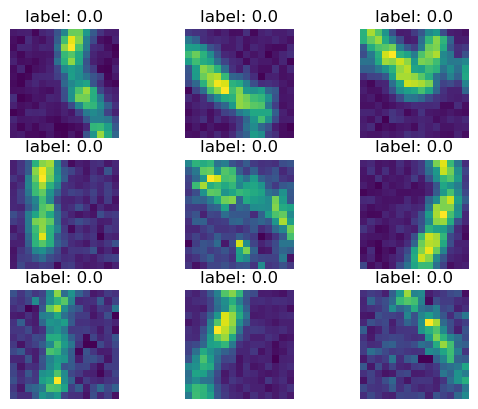

In [33]:
observations = os.listdir(os.path.join(out_dir, f"observations_{DATE}"))
training_annotations = pd.read_csv(glob(os.path.join(out_dir, "*_labels.csv"))[0])
ids = np.random.choice(len(training_annotations), size=9)
sample = training_annotations.iloc[ids]

fig, ax = plt.subplots(3,3)
ax = ax.flatten()
for i in range(len(ax)):
    img = torch.load(os.path.join(out_dir,f"observations_{DATE}", sample.iloc[i,0]), weights_only=True) # type: ignore
    ax[i].imshow(img[0].amax(0))
    ax[i].set_title(f"label: {sample.iloc[i,1].item()}")
    ax[i].set_axis_off()

    

## Train branch classifier

### Instantiate dataloader for training and test datasets
Dataloaders use a weighted random sampler to balance classes. Additionally, the training dataset\
 adds a random permutation and flip to the image patch at retrieval.

In [34]:
# set source data files paths
training_labels_file = os.path.join(out_dir, f"branch_classifier_neuromorpho_test_{DATE}_training_labels.csv")
test_labels_file = os.path.join(out_dir, f"branch_classifier_neuromorpho_test_{DATE}_test_labels.csv")
img_dir = os.path.join(out_dir, f"observations_{DATE}")

# instantiate training and test datasets
transform = branch_classifier.transform # random permutation and flip
training_data = branch_classifier.StateData(labels_file=training_labels_file,
                          img_dir=img_dir,
                          transform=transform)
test_data = branch_classifier.StateData(labels_file=test_labels_file,
                          img_dir=img_dir)

# instantiate dataloaders
training_dataloader = branch_classifier.init_dataloader(training_data, batchsize=64)
test_dataloader = branch_classifier.init_dataloader(test_data, batchsize=64)

## View balanced data

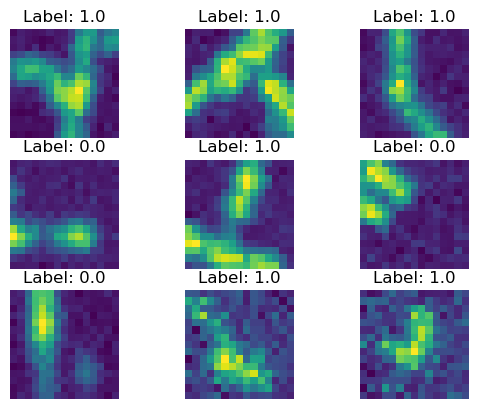

In [35]:
fig, axs = plt.subplots(3,3)
axs = axs.flatten()

X,y = next(iter(training_dataloader))
for i, ax in enumerate(axs):
    ax.imshow(X[i,0].amax(0))
    ax.set_title(f"Label: {y[i]}")
    ax.set_axis_off()

## Train

In [39]:
# instantiate and train the classifier
lr = 1e-3
epochs = 5
classifier = models.ResNet3D(models.ResidualBlock3D, [3, 4, 6, 3], num_classes=1)
classifier = classifier.to(device=DEVICE, dtype=DTYPE)

# Training logs are saved to the output directory
branch_classifier.train(training_dataloader, test_dataloader, out_dir, lr, epochs, classifier, state_dict=None)

Training epochs: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]


In [40]:
# Load and print training logs
logs = os.path.join(out_dir, "training_logs.txt")
with open(logs, "r") as f:
    lines = f.readlines()
    for line in lines:
        print(line.strip())

Training started at 2025-06-26 15:36:28
Learning rate: 0.001
Total epochs: 5

Epoch 1
-------------------------------
Accuracy: 45.3125, Loss: 0.700314  [   64/  720]
Accuracy: 56.25, Loss: 0.793185  [  704/  720]
Test Error:
Accuracy: 52.8%, Avg loss: 22.499360
Precision: 0.528, Recall: 1.000
Epoch 2
-------------------------------
Accuracy: 45.3125, Loss: 0.849842  [   64/  720]
Accuracy: 53.125, Loss: 0.673285  [  704/  720]
Test Error:
Accuracy: 59.4%, Avg loss: 9.390966
Precision: 1.000, Recall: 0.027
Epoch 3
-------------------------------
Accuracy: 62.5, Loss: 0.649782  [   64/  720]
Accuracy: 57.8125, Loss: 0.647150  [  704/  720]
Test Error:
Accuracy: 50.0%, Avg loss: 10.020075
Precision: 0.482, Recall: 0.964
Epoch 4
-------------------------------
Accuracy: 70.3125, Loss: 0.642213  [   64/  720]
Accuracy: 59.375, Loss: 0.614109  [  704/  720]
Test Error:
Accuracy: 47.8%, Avg loss: 0.919053
Precision: 0.571, Recall: 0.083
Epoch 5
-------------------------------
Accuracy: 64.06